## Pertpy cell type priorization with Augur

In [1]:
import scanpy as sc
import pertpy as pt
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

Running Scanpy 1.10.2, on 2024-08-07 10:47.


In [38]:
## plotting variables
plot_folder = "/media/HDD_1/Michael/Michelangelo/aging/augurpy/"
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['pdf.fonttype'] = 42

In [3]:
object_folder = "/media/HDD_1/Janine/Aging_SingleCell/data_objects/"
adata = sc.read(object_folder + "230111_Bleo_Ageing_annotated_final.h5ad") ### 3.9 GB ###

In [4]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 160477 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'name_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

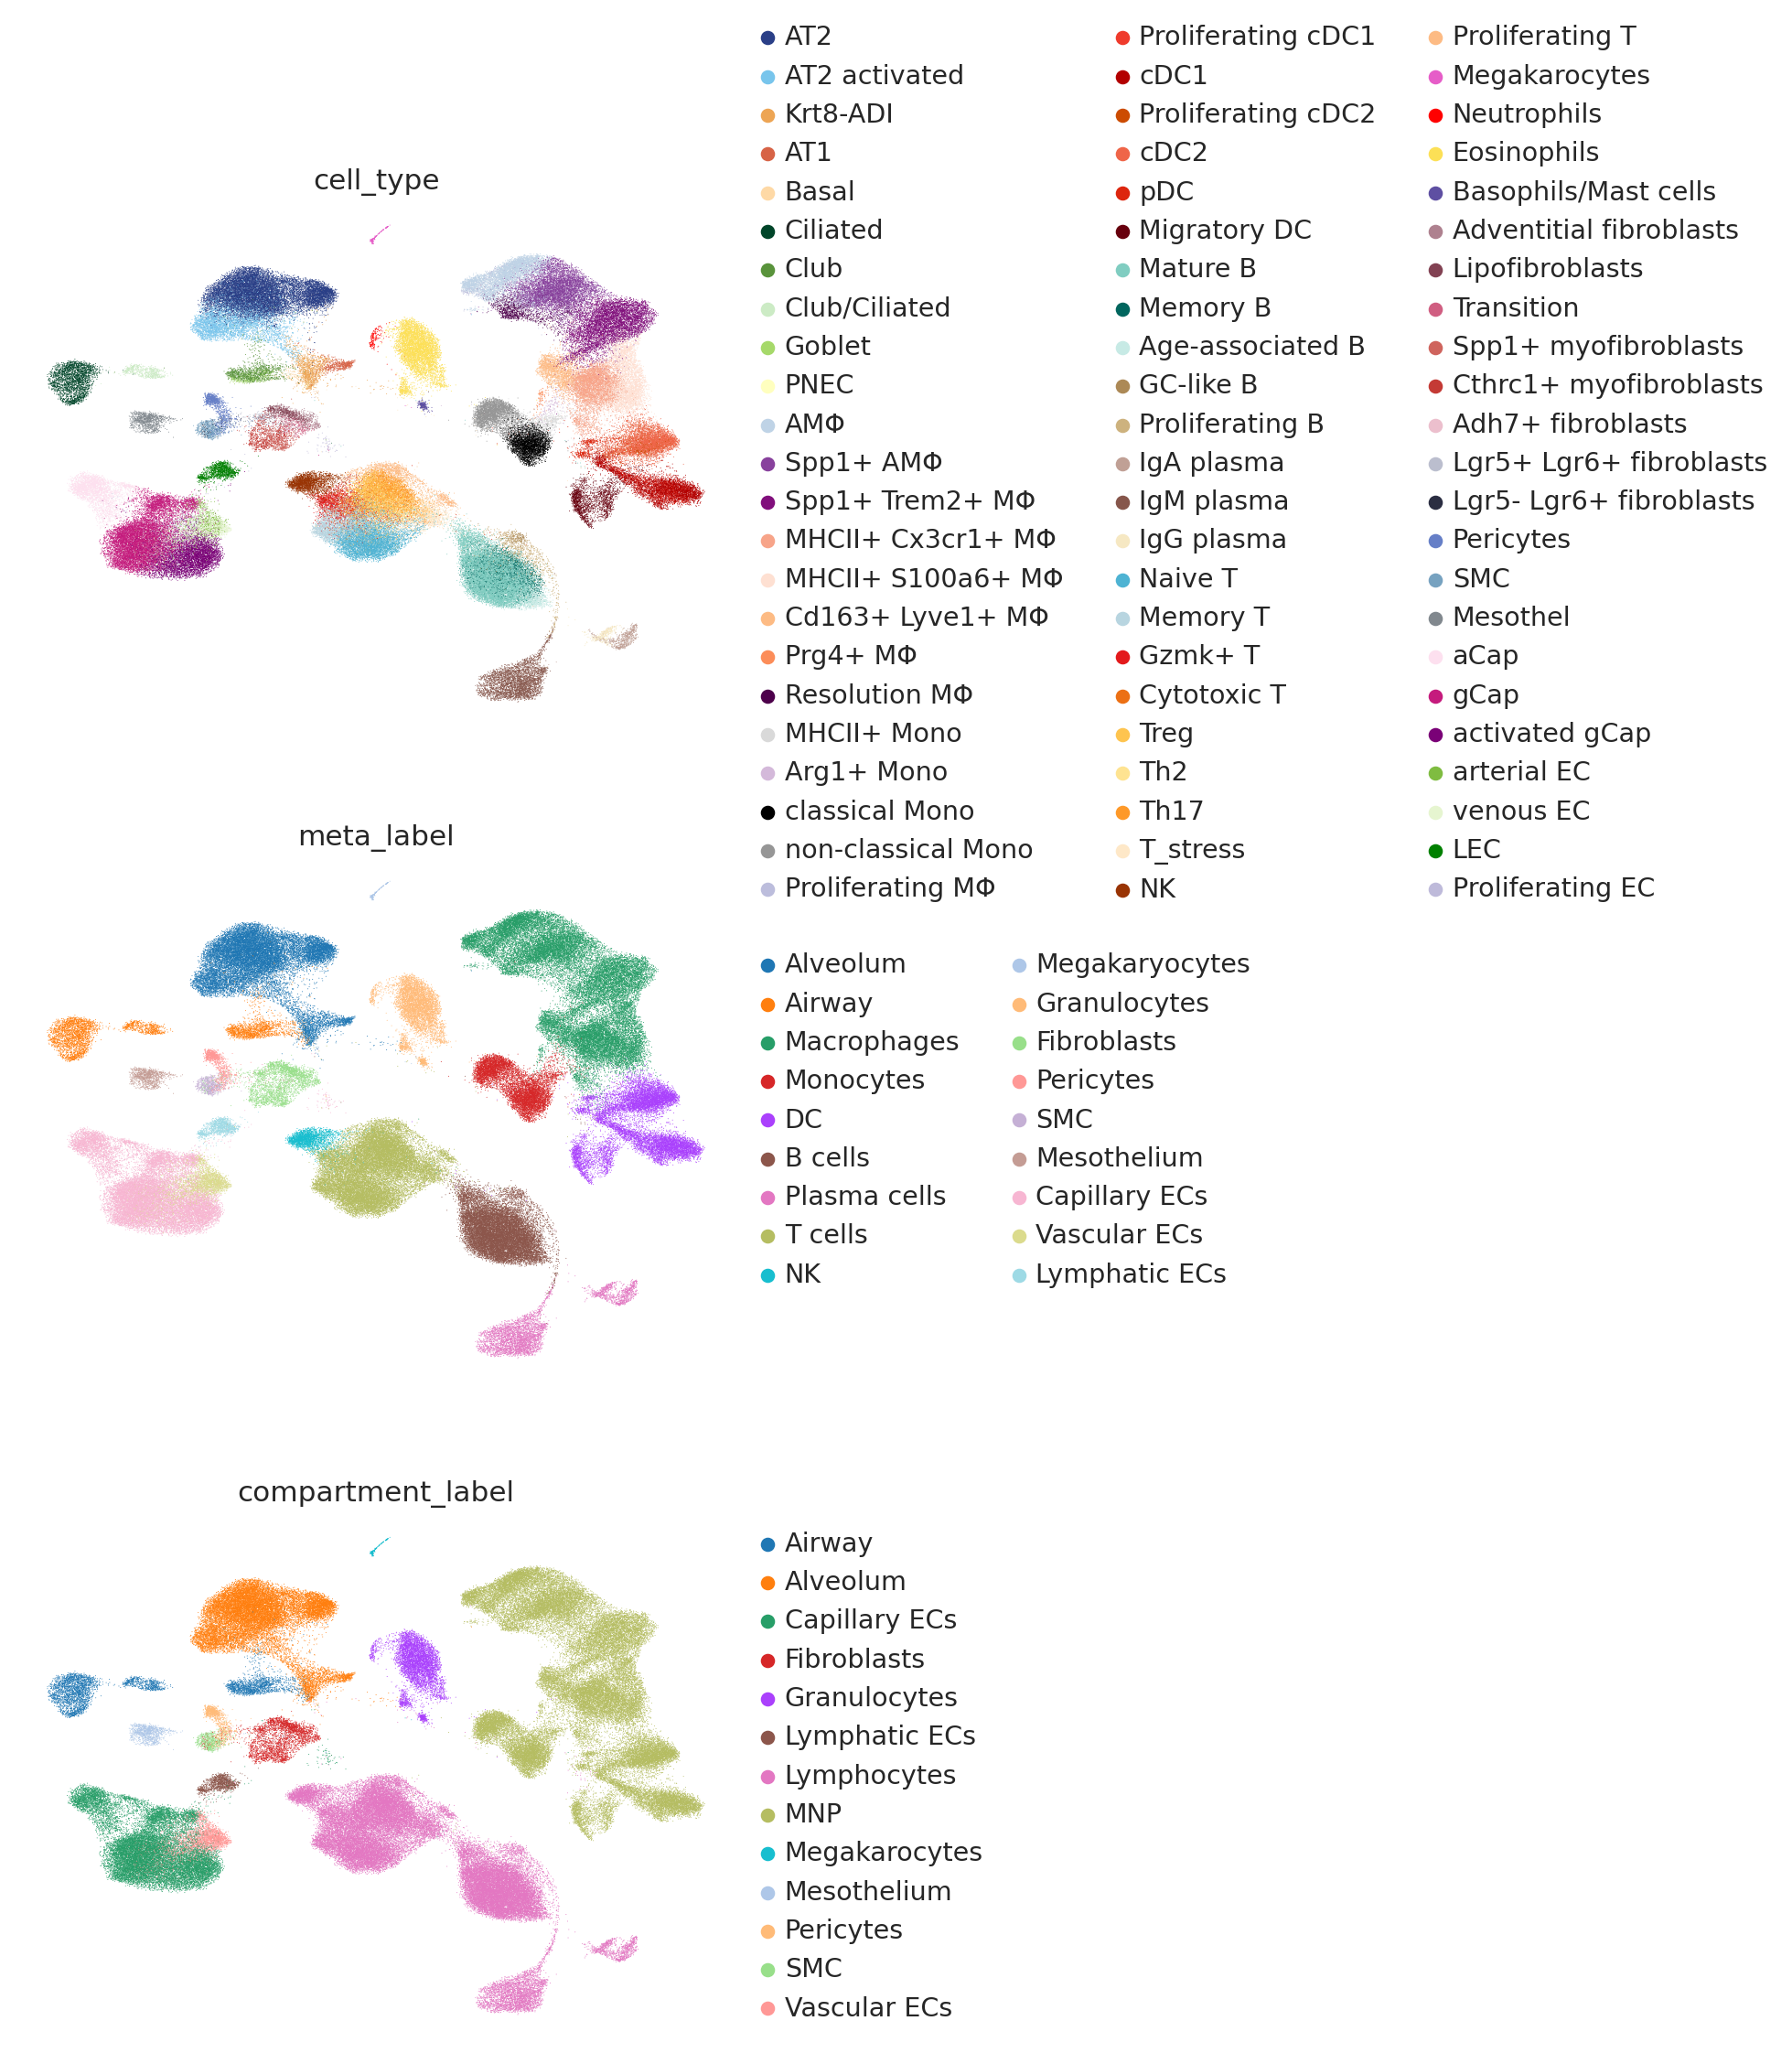

In [5]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type','meta_label', 'compartment_label'], ncols = 1, frameon = False)

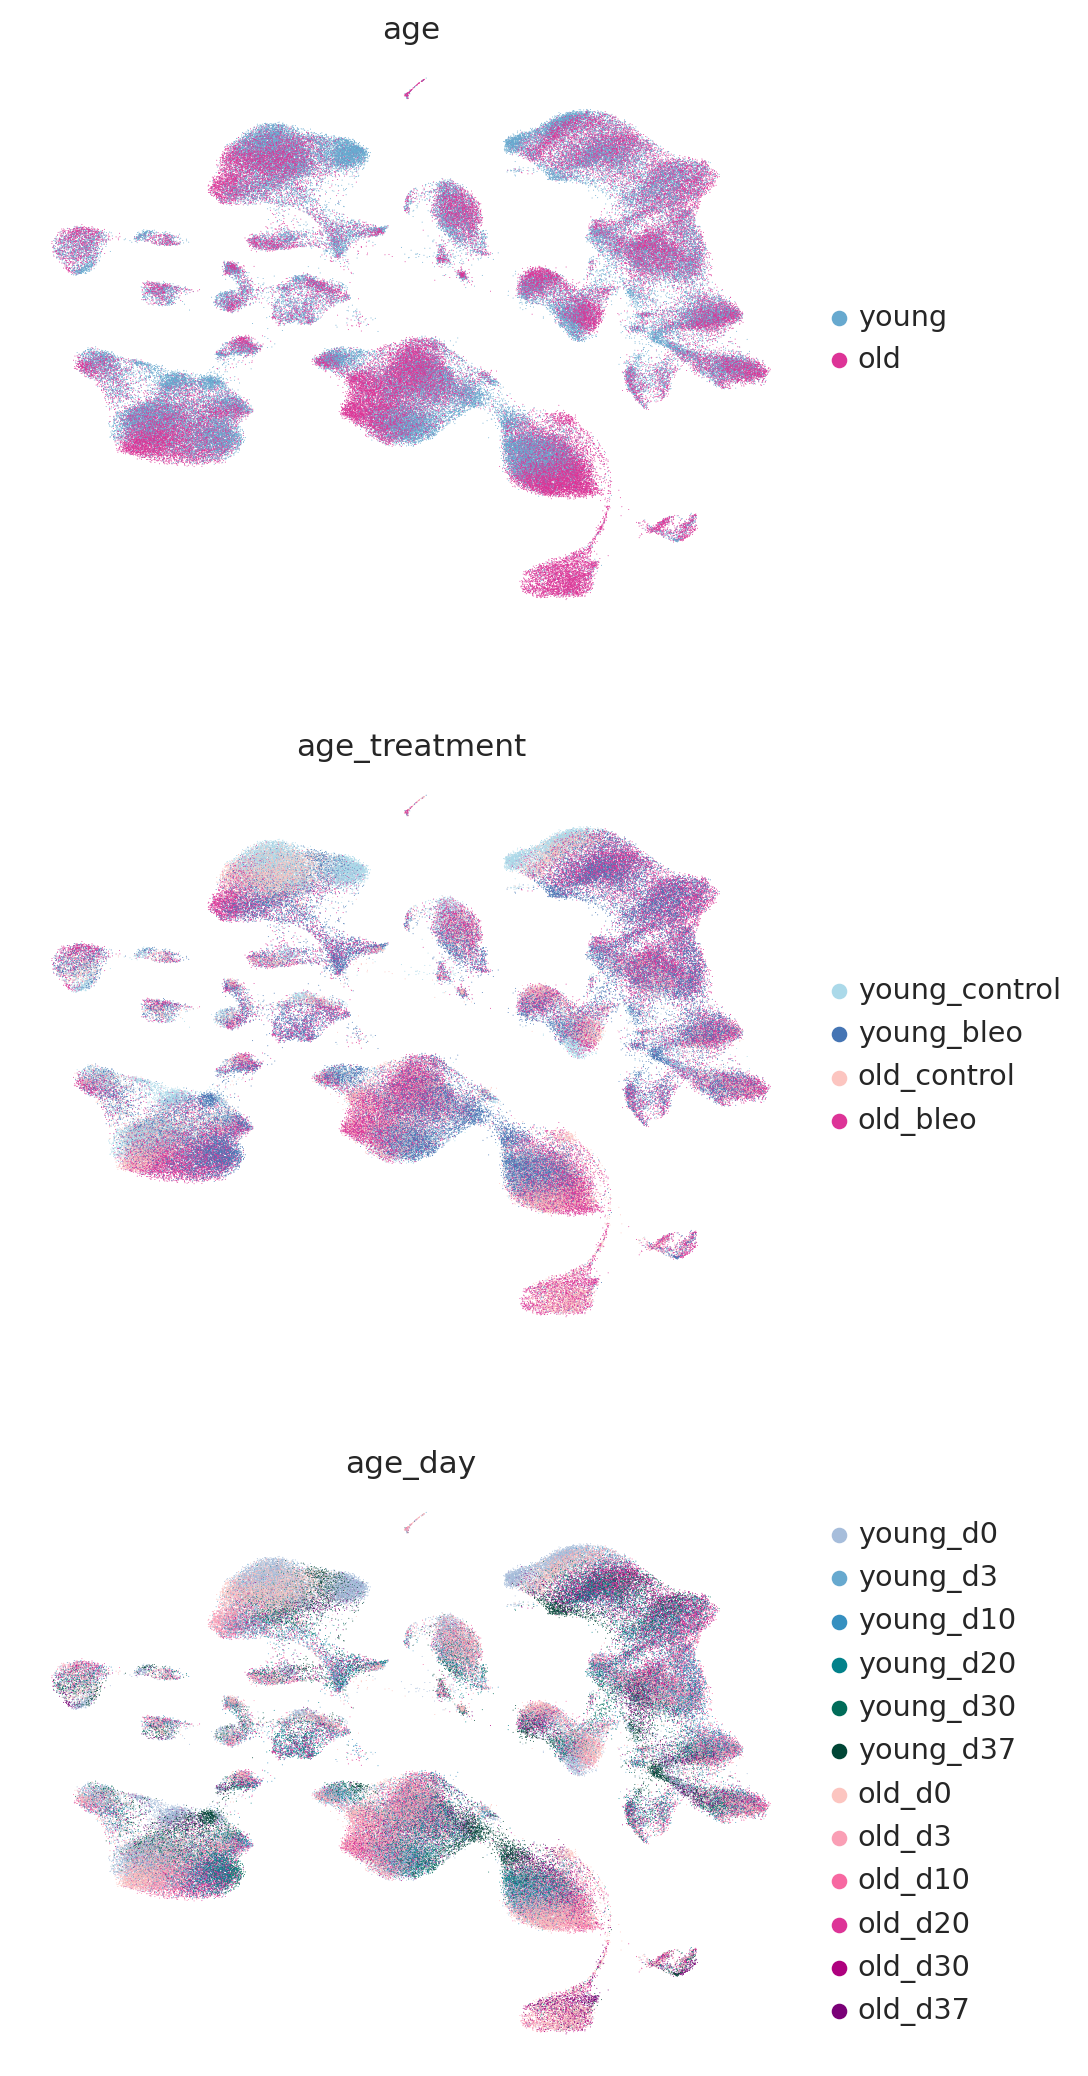

In [6]:
sc.pl.umap(adata, color = ['age','age_treatment', "age_day"], ncols = 1, frameon = False)

In [7]:
pd.crosstab(adata.obs['age_treatment'],adata.obs['meta_label'])

meta_label     Alveolum  Airway  Macrophages  Monocytes    DC  B cells  \
age_treatment                                                            
young_control      7531    1103         3576       1898  1415     2484   
young_bleo         5016    1494        13181       2024  5365     5271   
old_control        4019     769         2233       1741  1395     3481   
old_bleo           3180    1381        12139       2361  4724     6018   

meta_label     Plasma cells  T cells   NK  Megakaryocytes  Granulocytes  \
age_treatment                                                             
young_control            75     2770  667              31          1303   
young_bleo              467     7882  900              14          1751   
old_control            1643     3599  297              50          1005   
old_bleo               2456     9296  383              57          1882   

meta_label     Fibroblasts  Pericytes  SMC  Mesothelium  Capillary ECs  \
age_treatment                                                            
young_control          444        225  212          221           4345   
young_bleo            1345        386  210          357           6831   
old_control            297        155  115          191           3075   
old_bleo               960        291  180          297           5724   

meta_label     Vascular ECs  Lymphatic ECs  
age_treatment                               
young_control           583            165  
young_bleo             1013            438  
old_control             495            170  
old_bleo                998            427

In [8]:
pd.crosstab(adata.obs['age_treatment'],adata.obs['cell_type'])

cell_type       AT2  AT2 activated  Krt8-ADI  AT1  Basal  Ciliated  Club  \
age_treatment                                                              
young_control  7240            173        55   63      4       571   271   
young_bleo     1583           2310       821  302     67       788   407   
old_control    3603            307        40   69     12       386   219   
old_bleo        691           1963       373  153     58       710   387   

cell_type      Club/Ciliated  Goblet  PNEC  ...  Pericytes  SMC  Mesothel  \
age_treatment                               ...                             
young_control            212      39     6  ...        225  212       221   
young_bleo               151      71    10  ...        386  210       357   
old_control               96      54     2  ...        155  115       191   
old_bleo                 143      78     5  ...        291  180       297   

cell_type      aCap  gCap  activated gCap  arterial EC  venous EC  LEC  \
age_treatment                                                            
young_control   813  3322              80          230        353  165   
young_bleo      925  2724            2853          306        707  438   
old_control     497  2323             120          121        374  170   
old_bleo        667  2406            2432          214        784  427   

cell_type      Proliferating EC  
age_treatment                    
young_control               130  
young_bleo                  329  
old_control                 135  
old_bleo                    219  

[4 rows x 69 columns]

In [9]:
## random forest classifier for categorical 'age_treatment' variable
ag_rfc = pt.tl.Augur("random_forest_classifier")

In [10]:
adata.obs.rename(columns = {'cell_type': 'cell_type_resolved'}, inplace=True)

In [11]:
adata.obs.time_point

muc26493_TAGACTATTCGG    d0
muc26493_TCCGCTTTACAT    d0
muc26493_CGTGATGGAGTA    d0
muc26493_ATGTGCCCTTGA    d0
muc26493_TTGTTCGCTTGA    d0
                         ..
muc26548_GCGCCTAACGAC    d0
muc26548_AGGCCTAAACTC    d0
muc26548_CGACTGCTGTAG    d0
muc26548_TACTCCAGCAGA    d0
muc26548_CATTGACCTGGC    d0
Name: time_point, Length: 160477, dtype: category
Categories (6, object): ['d0', 'd3', 'd10', 'd20', 'd30', 'd37']

In [12]:
adata.obs.age

muc26493_TAGACTATTCGG    young
muc26493_TCCGCTTTACAT    young
muc26493_CGTGATGGAGTA    young
muc26493_ATGTGCCCTTGA    young
muc26493_TTGTTCGCTTGA    young
                         ...  
muc26548_GCGCCTAACGAC      old
muc26548_AGGCCTAAACTC      old
muc26548_CGACTGCTGTAG      old
muc26548_TACTCCAGCAGA      old
muc26548_CATTGACCTGGC      old
Name: age, Length: 160477, dtype: category
Categories (2, object): ['young', 'old']

In [13]:
adata1 = adata[adata.obs.time_point.isin(['d0'])].copy()

In [14]:
adata1

AnnData object with n_obs × n_vars = 53778 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type_resolved', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities

In [15]:
adata.obs

age barcode          batch day        name     sex  \
muc26493_TAGACTATTCGG  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_TCCGCTTTACAT  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_CGTGATGGAGTA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_ATGTGCCCTTGA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_TTGTTCGCTTGA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
...                      ...     ...            ...  ..         ...     ...   
muc26548_GCGCCTAACGAC    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_AGGCCTAAACTC    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_CGACTGCTGTAG    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_TACTCCAGCAGA    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_CATTGACCTGGC    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   

                      treatment identifier  n_counts  n_genes  ...  \
muc26493_TAGACTATTCGG   control   muc26493   14494.0     3719  ...   
muc26493_TCCGCTTTACAT   control   muc26493   14156.0     3870  ...   
muc26493_CGTGATGGAGTA   control   muc26493   13195.0     3409  ...   
muc26493_ATGTGCCCTTGA   control   muc26493   12685.0     4100  ...   
muc26493_TTGTTCGCTTGA   control   muc26493   12495.0     2951  ...   
...                         ...        ...       ...      ...  ...   
muc26548_GCGCCTAACGAC   control   muc26548     805.0      470  ...   
muc26548_AGGCCTAAACTC   control   muc26548     805.0      557  ...   
muc26548_CGACTGCTGTAG   control   muc26548     804.0      524  ...   
muc26548_TACTCCAGCAGA   control   muc26548     803.0      432  ...   
muc26548_CATTGACCTGGC   control   muc26548     803.0      550  ...   

                       time_point  leiden_1  leiden_2       domain  \
muc26493_TAGACTATTCGG          d0        16        33   Epithelium   
muc26493_TCCGCTTTACAT          d0        28        40   Epithelium   
muc26493_CGTGATGGAGTA          d0        16        33   Epithelium   
muc26493_ATGTGCCCTTGA          d0        28        40   Epithelium   
muc26493_TTGTTCGCTTGA          d0        16        33   Epithelium   
...                           ...       ...       ...          ...   
muc26548_GCGCCTAACGAC          d0        13        10   Leukocytes   
muc26548_AGGCCTAAACTC          d0         0         2  Endothelium   
muc26548_CGACTGCTGTAG          d0         4         1   Leukocytes   
muc26548_TACTCCAGCAGA          d0         5         6   Epithelium   
muc26548_CATTGACCTGGC          d0         6         4   Leukocytes   

                       cell_type_resolved      ct_level2 compartment_label  \
muc26493_TAGACTATTCGG                Club           Club            Airway   
muc26493_TCCGCTTTACAT       Club/Ciliated  Club/Ciliated            Airway   
muc26493_CGTGATGGAGTA              Goblet         Goblet            Airway   
muc26493_ATGTGCCCTTGA       Club/Ciliated  Club/Ciliated            Airway   
muc26493_TTGTTCGCTTGA                Club           Club            Airway   
...                                   ...            ...               ...   
muc26548_GCGCCTAACGAC         Eosinophils    Eosinophils      Granulocytes   
muc26548_AGGCCTAAACTC                gCap           gCap     Capillary ECs   
muc26548_CGACTGCTGTAG             Gzmk+ T        Gzmk+ T       Lymphocytes   
muc26548_TACTCCAGCAGA                 AT2            AT2          Alveolum   
muc26548_CATTGACCTGGC                Th17        Thelper       Lymphocytes   

                          meta_label  age_treatment   age_day  
muc26493_TAGACTATTCGG         Airway  young_control  young_d0  
muc26493_TCCGCTTTACAT         Airway  young_control  young_d0  
muc26493_CGTGATGGAGTA         Airway  young_control  young_d0  
muc26493_ATGTGCCCTTGA         Airway  young_control  young_d0  
muc26493_TTGTTCGCTTGA         Airway  young_control  young_d0  
...                              ...            ...       ...  
muc26548_

In [16]:
loaded_data1 = ag_rfc.load(adata1, label_col="age", cell_type_col="meta_label")
loaded_data1

AnnData object with n_obs × n_vars = 53778 × 29814
    obs: 'label', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type_resolved', 'ct_level2', 'compartment_label', 'cell_type', 'age_treatment', 'age_day', 'y_'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

In [17]:
loaded_data1.obs

label barcode          batch day        name     sex  \
muc26493_TAGACTATTCGG  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_TCCGCTTTACAT  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_CGTGATGGAGTA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_ATGTGCCCTTGA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_TTGTTCGCTTGA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
...                      ...     ...            ...  ..         ...     ...   
muc26548_GCGCCTAACGAC    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_AGGCCTAAACTC    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_CGACTGCTGTAG    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_TACTCCAGCAGA    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_CATTGACCTGGC    old    N706  ageing_pool_4  d0  oCf-d0-M57  female   

                      treatment identifier  n_counts  n_genes  ...  leiden_1  \
muc26493_TAGACTATTCGG   control   muc26493   14494.0     3719  ...        16   
muc26493_TCCGCTTTACAT   control   muc26493   14156.0     3870  ...        28   
muc26493_CGTGATGGAGTA   control   muc26493   13195.0     3409  ...        16   
muc26493_ATGTGCCCTTGA   control   muc26493   12685.0     4100  ...        28   
muc26493_TTGTTCGCTTGA   control   muc26493   12495.0     2951  ...        16   
...                         ...        ...       ...      ...  ...       ...   
muc26548_GCGCCTAACGAC   control   muc26548     805.0      470  ...        13   
muc26548_AGGCCTAAACTC   control   muc26548     805.0      557  ...         0   
muc26548_CGACTGCTGTAG   control   muc26548     804.0      524  ...         4   
muc26548_TACTCCAGCAGA   control   muc26548     803.0      432  ...         5   
muc26548_CATTGACCTGGC   control   muc26548     803.0      550  ...         6   

                       leiden_2       domain  cell_type_resolved  \
muc26493_TAGACTATTCGG        33   Epithelium                Club   
muc26493_TCCGCTTTACAT        40   Epithelium       Club/Ciliated   
muc26493_CGTGATGGAGTA        33   Epithelium              Goblet   
muc26493_ATGTGCCCTTGA        40   Epithelium       Club/Ciliated   
muc26493_TTGTTCGCTTGA        33   Epithelium                Club   
...                         ...          ...                 ...   
muc26548_GCGCCTAACGAC        10   Leukocytes         Eosinophils   
muc26548_AGGCCTAAACTC         2  Endothelium                gCap   
muc26548_CGACTGCTGTAG         1   Leukocytes             Gzmk+ T   
muc26548_TACTCCAGCAGA         6   Epithelium                 AT2   
muc26548_CATTGACCTGGC         4   Leukocytes                Th17   

                           ct_level2 compartment_label      cell_type  \
muc26493_TAGACTATTCGG           Club            Airway         Airway   
muc26493_TCCGCTTTACAT  Club/Ciliated            Airway         Airway   
muc26493_CGTGATGGAGTA         Goblet            Airway         Airway   
muc26493_ATGTGCCCTTGA  Club/Ciliated            Airway         Airway   
muc26493_TTGTTCGCTTGA           Club            Airway         Airway   
...                              ...               ...            ...   
muc26548_GCGCCTAACGAC    Eosinophils      Granulocytes   Granulocytes   
muc26548_AGGCCTAAACTC           gCap     Capillary ECs  Capillary ECs   
muc26548_CGACTGCTGTAG        Gzmk+ T       Lymphocytes        T cells   
muc26548_TACTCCAGCAGA            AT2          Alveolum       Alveolum   
muc26548_CATTGACCTGGC        Thelper       Lymphocytes        T cells   

                       age_treatment   age_day y_  
muc26493_TAGACTATTCGG  young_control  young_d0  1  
muc26493_TCCGCTTTACAT  young_control  young_d0  1  
muc26493_CGTGATGGAGTA  young_control  young_d0  1  
muc26493_ATGTGCCCTTGA  young_control  young_d0  1  
muc26493_TTGTTCGCTTGA  young_control  young_d0  1  
...                              ...       ... ..  
muc26548_GCGCCTAACGAC    old_control    old_d0  0  
muc

In [18]:
loaded_data1.var['name'] = loaded_data1.var_names

In [19]:
baseline_adata, baseline_results = ag_rfc.predict(
    loaded_data1, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True)

baseline_results["summary_metrics"]

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Skipping Megakaryocytes cell type - 81 samples is less than min_cells 100.

Airway  Mesothelium  Macrophages   T cells  Alveolum  \
mean_augur_score  0.559365     0.533798     0.571190  0.548798  0.624104   
mean_auc          0.559365     0.533798     0.571190  0.548798  0.624104   
mean_accuracy     0.543040     0.508425     0.536538  0.529963  0.564542   
mean_precision    0.545697     0.498095     0.536202  0.527952  0.563505   
mean_f1           0.530375     0.528341     0.567314  0.544890  0.598274   
mean_recall       0.573175     0.625317     0.649206  0.624921  0.685873   

                        DC  Vascular ECs  Plasma cells  Lymphatic ECs  \
mean_augur_score  0.600108      0.541593      0.585340       0.607738   
mean_auc          0.600108      0.541593      0.585340       0.607738   
mean_accuracy     0.553260      0.514780      0.551740       0.554615   
mean_precision    0.542656      0.519679      0.573769       0.544592   
mean_f1           0.589945      0.524221      0.496236       0.583181   
mean_recall       0.690159      0.594603      0.491825       0.689048   

                  Fibroblasts  Capillary ECs   B cells  Monocytes       SMC  \
mean_augur_score     0.570975       0.556633  0.554926   0.541780  0.557948   
mean_auc             0.570975       0.556633  0.554926   0.541780  0.557948   
mean_accuracy        0.536905       0.521026  0.530678   0.516538  0.526355   
mean_precision       0.533614       0.519899  0.534057   0.526528  0.520730   
mean_f1              0.567114       0.532047  0.553771   0.466723  0.574064   
mean_recall          0.669206       0.594603  0.635079   0.475556  0.689048   

                  Pericytes        NK  Granulocytes  
mean_augur_score   0.522449  0.499121      0.585992  
mean_auc           0.522449  0.499121      0.585992  
mean_accuracy      0.504011  0.494817      0.560073  
mean_precision     0.496170  0.483375      0.575863  
mean_f1            0.511422  0.435705      0.538328  
mean_recall        0.591190  0.464921      0.562937

/tmp/ipykernel_3721640/2437335562.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(baseline_results)


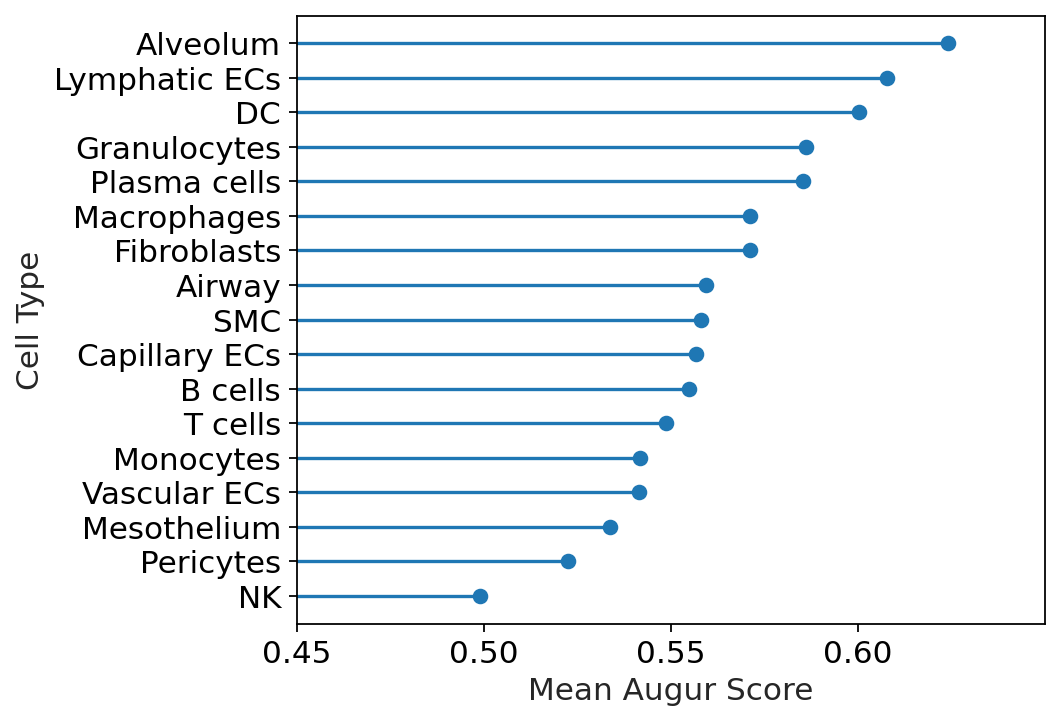

In [43]:
pt.pl.ag.lollipop(baseline_results)
plt.xlim([0.45, 0.65])
plt.xticks(np.arange(0.45, 0.65, step=0.05))
#plt.yticks(fontsize = 5) 
plt.grid(False)
plt.savefig(plot_folder + 'pertpy_baseline_d0_meta_label.pdf')

/tmp/ipykernel_3721640/1835546308.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(baseline_results, top_n=15)


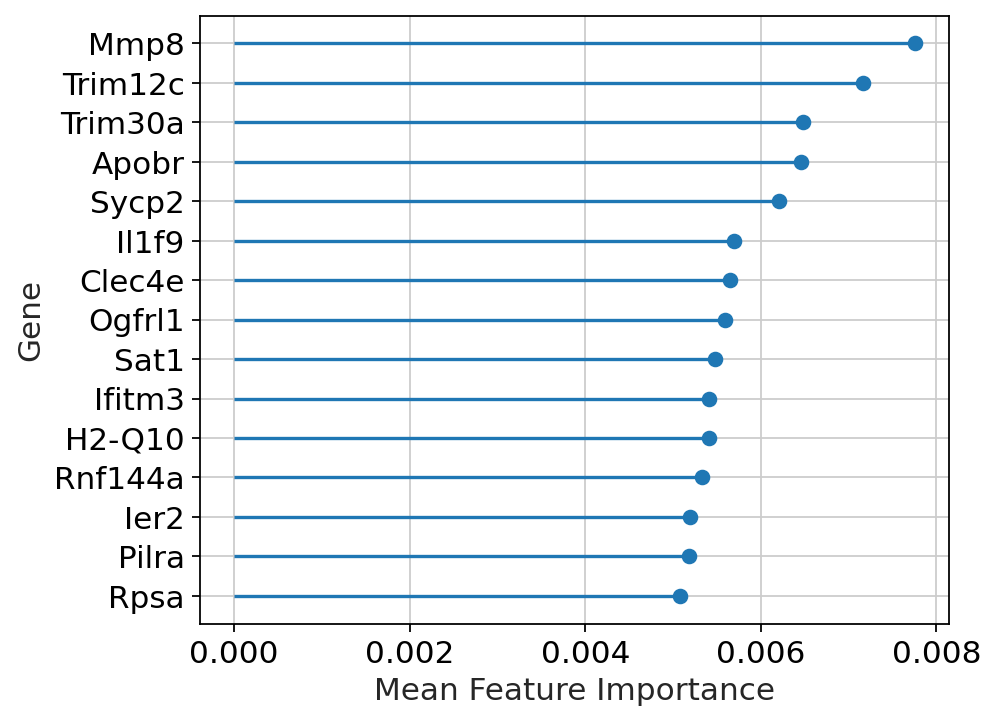

In [21]:
important_features = pt.pl.ag.important_features(baseline_results, top_n=15)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


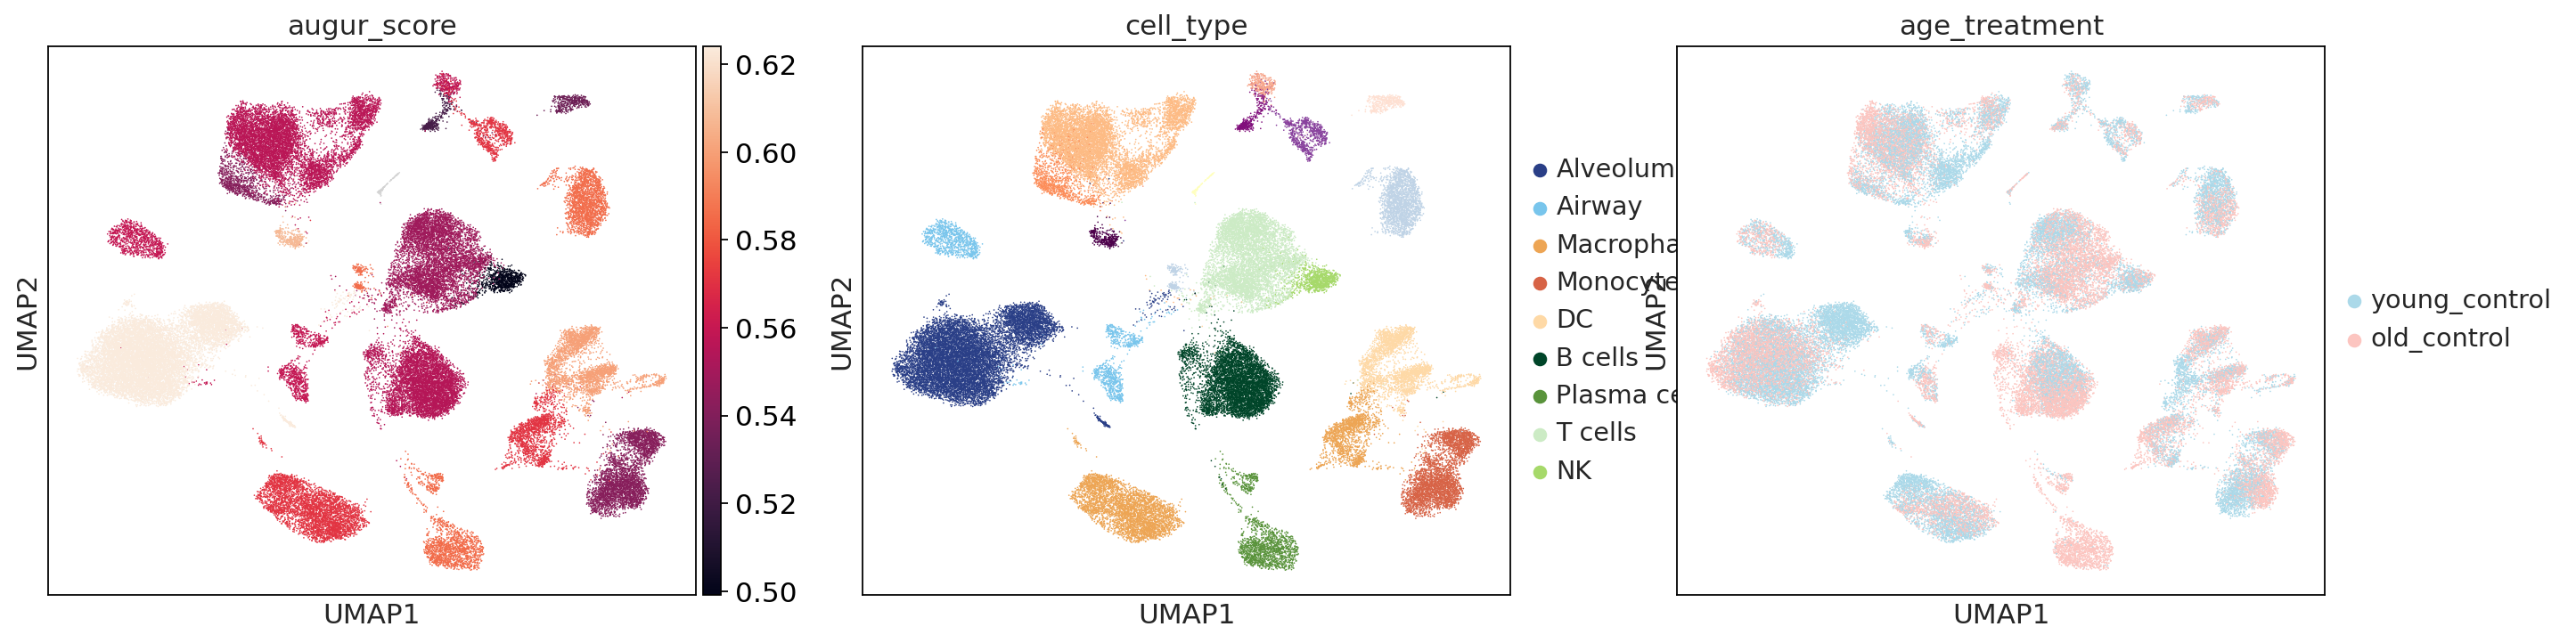

In [22]:
sc.pp.neighbors(baseline_adata)
sc.tl.umap(baseline_adata)
sc.pl.umap(adata=baseline_adata, color=["augur_score", "cell_type", "age_treatment"])

In [23]:
baseline_results['summary_metrics']

Airway  Mesothelium  Macrophages   T cells  Alveolum  \
mean_augur_score  0.559365     0.533798     0.571190  0.548798  0.624104   
mean_auc          0.559365     0.533798     0.571190  0.548798  0.624104   
mean_accuracy     0.543040     0.508425     0.536538  0.529963  0.564542   
mean_precision    0.545697     0.498095     0.536202  0.527952  0.563505   
mean_f1           0.530375     0.528341     0.567314  0.544890  0.598274   
mean_recall       0.573175     0.625317     0.649206  0.624921  0.685873   

                        DC  Vascular ECs  Plasma cells  Lymphatic ECs  \
mean_augur_score  0.600108      0.541593      0.585340       0.607738   
mean_auc          0.600108      0.541593      0.585340       0.607738   
mean_accuracy     0.553260      0.514780      0.551740       0.554615   
mean_precision    0.542656      0.519679      0.573769       0.544592   
mean_f1           0.589945      0.524221      0.496236       0.583181   
mean_recall       0.690159      0.594603      0.491825       0.689048   

                  Fibroblasts  Capillary ECs   B cells  Monocytes       SMC  \
mean_augur_score     0.570975       0.556633  0.554926   0.541780  0.557948   
mean_auc             0.570975       0.556633  0.554926   0.541780  0.557948   
mean_accuracy        0.536905       0.521026  0.530678   0.516538  0.526355   
mean_precision       0.533614       0.519899  0.534057   0.526528  0.520730   
mean_f1              0.567114       0.532047  0.553771   0.466723  0.574064   
mean_recall          0.669206       0.594603  0.635079   0.475556  0.689048   

                  Pericytes        NK  Granulocytes  
mean_augur_score   0.522449  0.499121      0.585992  
mean_auc           0.522449  0.499121      0.585992  
mean_accuracy      0.504011  0.494817      0.560073  
mean_precision     0.496170  0.483375      0.575863  
mean_f1            0.511422  0.435705      0.538328  
mean_recall        0.591190  0.464921      0.562937

In [33]:
baseline_scores = baseline_results['summary_metrics'].loc['mean_augur_score',]
compartment_baseline_scores = compartment_baseline_results['summary_metrics'].loc['mean_augur_score',]

In [41]:
## Save the Marker Table
out_folder = "/media/HDD_1/Michael/Michelangelo/aging/augurpy/"
baseline_scores.to_csv(out_folder + "baseline_d0_augur_scores.txt", sep = "\t")